In [291]:
# Loading Required Packages 
import cobra
from cobra.flux_analysis import flux_variability_analysis
import pandas as pd
import numpy as np
import itertools

# Loading the Model 
model = cobra.io.read_sbml_model("ArabidopsisCoreModel1.xml")

# Changing the directionality of Fum_c to Mal_c to go the other way (day-time model) 
r = model.reactions.get_by_id('FumHA_c')
r.add_metabolites({model.metabolites.get_by_id('Fum_c'): +2})
r.add_metabolites({model.metabolites.get_by_id('H2O_c'): +2})
r.add_metabolites({model.metabolites.get_by_id('Mal_c'): -2})
print(r.reaction)
print(r.bounds)
print("Directionality changed. Dyson et al. 2016 \n")

# Creating a Malate "Storage" Reactions
r = cobra.Reaction('Mal_Store')
r.name = 'Mal_Store'
r.add_metabolites({model.metabolites.get_by_id('Mal_c'): -1})
model.add_reaction(r)
print(r.reaction)

# Creating a Fumarate "Storage" Reactions
r = cobra.Reaction('Fum_Store')
r.name = 'Fum_Store'
r.add_metabolites({model.metabolites.get_by_id('Fum_c'): -1})
model.add_reaction(r)
print(r.reaction)

# Creating a Starch "Storage" Reactions
r = cobra.Reaction('Starch_Store')
r.name = 'Starch_Store'
r.add_metabolites({model.metabolites.get_by_id('starch1_h'): -1})
model.add_reaction(r)
print(r.reaction)

cobra/core/reaction.py:394 UserWarning: malformed gene_reaction_rule '2*(ATCG00020 and ATCG00680 and ATCG00280 and ATCG00270 and ATCG00580 and ATCG00570 and ATCG00710 and ATCG00080 and ATCG00550 and ATCG00070 and ATCG00560 and ATCG00220 and ATCG00700 and (AT5G66570 or AT3G50820) and AT1G06680 and (AT4G21280 or AT4G05180) and AT1G79040 and AT1G44575 and ATCG00690 and AT3G21055 and AT2G30570 and AT2G06520 and AT1G67740 and ATCG00300)' for <Reaction PSII_h at 0x7fc55197d9d0>
cobra/core/reaction.py:394 UserWarning: malformed gene_reaction_rule '2*(ATCG00540 and ATCG00720 and AT4G03280 and ATCG00730 and ATCG00600 and ATCG00590 and AT2G26500 and ATCG00210)' for <Reaction Cytb6f_h at 0x7fc55197db50>
cobra/core/reaction.py:394 UserWarning: malformed gene_reaction_rule '8*(ATCG00490) and 8*(AT5G38430 or AT5G38420 or AT1G67090 or AT5G38410)' for <Reaction RBC_h at 0x7fc55197dc90>
cobra/core/reaction.py:394 UserWarning: malformed gene_reaction_rule '4*(AT3G26650 or AT1G12900) or (2*(AT3G26650 or 

Mal_c --> Fum_c + H2O_c
(0.0, 1000.0)
Directionality changed. Dyson et al. 2016 

Mal_c --> 
Fum_c --> 
starch1_h --> 


In [354]:
# Removing small metbaolites, generic compounds, ligand complexes, and cofactor to be removed from the model
rem_names = ["CO2_c","CO2_h","CO2_m","ATP_c","ATP_h","ATP_m","ADP_c","ADP_h","ADP_m",
             "NADP_c","NADP_h","NADP_m","NADPH_c","NADPH_h","NADPH_m",
             "NAD_c","NAD_h","NAD_m","NAD_p","NADH_c","NADH_h","NADH_m","NADH_p",
             "cellulose1_c","cellulose2_c","cellulose3_c",
             #"Mal_c", # test that network breaks for the mutant
             #"Mal_h",
             "Fum_h","Fum_m","SCA_c", # because otherwise the mutant would work
             # Note sure of these next 3 lines... 
             "KG_c","KG_h","KG_m","KG_p",
             "Glu_p","Gly_p","Glu_m","Gly_m","Glu_c","Gly_c","Glu_h","Gly_h",
             #"CoA_m","CoA_c","CoA_h",
             # Remove conversion steps 
             "M_DASH_CoA_h","A_DASH_CoA_m","A_DASH_CoA_c","A_DASH_CoA_h","P_DASH_HPR_h","H_DASH_Eth_DASH_ThPP_m",
             "A_DASH_DHL_m","S_DASH_CoA_m","M_DASH_THF_m","M_DASH_ACP_h","F_DASH_THF_h","A_DASH_Glu_h",
             "A_DASH_GluP_h","H_DASH_Ser_h","PH_DASH_Ser_h","H_DASH_Cys_h","M_DASH_THF_c","5M_DASH_THF_c",
             "H_DASH_Cys_c","A_DASH_Glu_DASH_SeA_h","aH_DASH_Cys_c","PR_DASH_ATP_h","PR_DASH_AMP_h",
             "P_DASH_AICAR_DASH_P_h","Pu_DASH_AICAR_DASH_P_h","IA_DASH_P_h","Hisol_DASH_P_h","Asp_DASH_SeA_h",
             "H_DASH_Eth_DASH_ThPP_h","Glu_DASH_SeA_m","Glu_DASH_SeA_c","Glu_DASH_SeA_h","A_DASH_Orn_h",
             "PR_DASH_ANT_h","CPD_DASH_Ru5P_h","DC_DASH_AMP_h","Ind_DASH_GP_h","Arg_DASH_SCA_h","A_DASH_Ser_c",
             "A_DASH_Ser_h","SCA_DASH_SeA_m","CB_DASH_Asp_h","A_DASH_Ser_m","S_DASH_DHL_m",
             # Remove amino acids 
             "Asp_h","Asp_h","Arg_h","Arg_h","Asp_c","Ala_p","Asp_p","Asp_m","Ala_m","Ala_h",
             "Ala_c","Arg_c","Lys_c","Lys_m","His_m","His_c","DHO_c","Arg_p","Asn_p","Cys_p","Gln_p","His_p","Ile_c",
             "Ile_p","Leu_c","Leu_p","Lys_p","Met_p","Phe_c","Phe_p","Pro_p","Thr_p","Trp_c","Trp_p","Tyr_c","Tyr_p",
             "Val_c","Val_p","Asn_h","Asn_m","Ile_m","Leu_m","Met_h","Met_m","Phe_m","Pro_h","Thr_m","Trp_m","Tyr_m",
             "Val_m"]
             #"Q_m","QH2_m","Cytcox_m","Cytcrd_m","LPL_m","amDHP_m","DHP_m","THF_m",]

#Set OAA_c to PEP_c to be non-reversible
r = model.reactions.get_by_id("PEPC2_c")
r.lower_bound = 0.0
print(r.reaction)

OAA_c + Pi_c --> HCO3_c + PEP_c


In [355]:
# Creating a metabolite to metabolite graph 
import networkx as nx
import itertools
G = nx.DiGraph()
# Adding the nodes 
for m in model.metabolites:
    # Adding only the carbon backbone
    if "C"  in m.formula:
        if m.id not in rem_names:
            G.add_node(m.id)
            print(m.id)
            print(m.name)
# Adding the edges 
for r in model.reactions:
    prods = []
    reacs = []
    for p in r.products:
        if "C"  in p.formula:
            if p.id not in rem_names:
                prods.append(p.id)
    for s in r.reactants:
        if "C"  in s.formula:
            if s.id not in rem_names:
                reacs.append(s.id)
    if r.lower_bound == 0.0:
        # Forward Reactions
        G.add_edges_from(list(itertools.product(reacs, prods)))
    if r.lower_bound < 0.0:
        # Reversible Reactions
        G.add_edges_from(list(itertools.product(reacs, prods)))
        G.add_edges_from(list(itertools.product(prods, reacs)))
# Graph properties
print(G.number_of_nodes())
print(G.number_of_edges())
# list(G.neighbors('Fum_c'))

PQ_h
Oxidized plastoquinone
PQH2_h
Reduced plastoquinone
RuBP_h
Ribulose 1,5-bisphosphate
PGA_h
3-Phosphoglycerate
DPGA_h
3-Phospho-D-glyceroyl phosphate
GAP_h
Glyceraldehyde 3-phosphate
DHAP_h
Dihydroxyacetone phosphate
FBP_h
Fructose 1,6-bisphosphate
F6P_h
Fructose 6-phosphate
E4P_h
Erythrose 4-phosphate
X5P_h
Xylulose 5-phosphate
SBP_h
Sedoheptulose 1,7-bisphosphate
S7P_h
Sedoheptulose 7-phosphate
R5P_h
Ribose 5-phosphate
Ru5P_h
Ribulose 5-phosphate
G6P_h
Glucose 6-phosphate
G1P_h
Glucose 1-phosphate
ADPG_h
ADP-Glucose
starch1_h
Starch, X+1 glucose units
starch2_h
Starch, X+2 glucose units
starch3_h
Starch, X+3 glucose units
starch5_h
Starch, X+5 glucose units
Mas_h
Maltose
Glc_h
Glucose
starch1_c
Starch, X+1 glucose units
Mas_c
Maltose
starch2_c
Starch, X+2 glucose units
Glc_c
Glucose
G6P_c
Glucose 6-phosphate
G1P_c
Glucose 1-phosphate
GAP_c
Glyceraldehyde 3-phosphate
DHAP_c
Dihydroxyacetone phosphate
FBP_c
Fructose 1,6-bisphosphate
F6P_c
Fructose 6-phosphate
F26BP_c
Fructose 2,6-b

In [356]:
# Computing the shortest path for fumarate production
for p in nx.all_shortest_paths(G, "RuBP_h", "Fum_c"):
    print(p)
    print(" ")

NetworkXNoPath: Target Fum_c cannot be reachedfrom Source RuBP_h

In [349]:
print(p)

['RuBP_h', 'PGCA_h', 'GCA_h', 'GLX_h', 'KG_h', 'OAA_h', 'Mal_h', 'Mal_c', 'Fum_c']


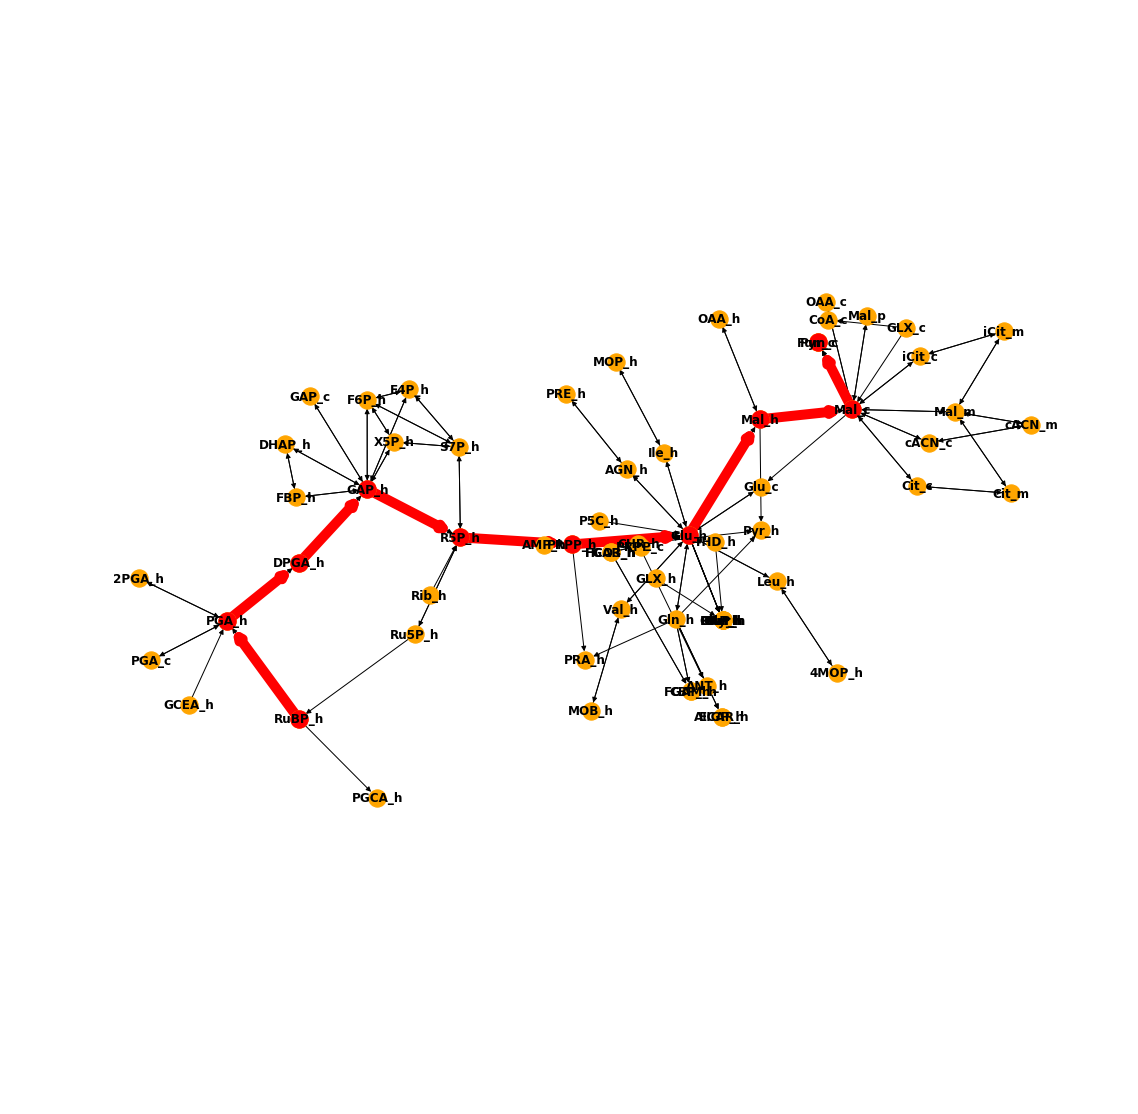

In [342]:
# Creating a subnetwork from the shortest path 
Gsub = nx.DiGraph()
Gsub.add_nodes_from(p)
# Add all reactions in which those nodes are involved in 
reacs = []
for i in p:
    metabo = model.metabolites.get_by_id(i)
    for re in metabo.reactions:
        reacs.append(re)
for r in reacs:
    prods = []
    reacs = []
    for prod in r.products:
        if "C"  in prod.formula:
            if prod.id not in rem_names:
                prods.append(prod.id)
    for s in r.reactants:
        if "C"  in s.formula:
            if s.id not in rem_names:
                reacs.append(s.id)
    if r.lower_bound == 0.0:
        # Forward Reactions
        Gsub.add_edges_from(list(itertools.product(reacs, prods)))
    if r.lower_bound < 0.0:
        # Reversible Reactions
        Gsub.add_edges_from(list(itertools.product(reacs, prods)))
        Gsub.add_edges_from(list(itertools.product(prods, reacs)))

# Drawing in the subnetwork and the shortest path      
import matplotlib.pyplot as plt
pos = nx.kamada_kawai_layout(Gsub)
plt.figure(figsize=(15,15))
plt.tight_layout
nx.draw(Gsub,pos,with_labels=True,font_weight='bold',node_color='orange')
# draw path in red
path = p
path_edges = zip(path,path[1:]) 
nx.draw_networkx_nodes(Gsub,pos,nodelist=path,node_color='r',with_labels=False)
nx.draw_networkx_edges(Gsub,pos,edgelist=path_edges,edge_color='r',width=10)
plt.axis('equal')
plt.show()

In [250]:
m = model.metabolites.get_by_id("OAA_c")
for r in m.reactions:
    print(r.reaction)
    print(r.id)

OAA_c + iCit_m <=> OAA_m + iCit_c
Tr_DTC3B
NADPH_c + OAA_c --> Mal_c + NADP_c
MalDH3_c
OAA_c + Pi_c --> HCO3_c + PEP_c
PEPC2_c
OAA_c + cACN_m <=> OAA_m + cACN_c
Tr_DTC3C
Mal_c + NAD_c <=> NADH_c + OAA_c
MalDH1_c
Glu_c + OAA_c <=> Asp_c + KG_c
AspAT_c
OAA_c <=> OAA_p
Tr_OAA
ATP_c + OAA_c --> ADP_c + CO2_c + PEP_c
PEPC1_c
Cit_m + OAA_c <=> Cit_c + OAA_m
Tr_DTC3A
ATP_c + Cit_c + CoA_c --> ADP_c + A_DASH_CoA_c + OAA_c + Pi_c
ATPCitL_c
A_DASH_CoA_c + H2O_c + OAA_c --> Cit_c + CoA_c + H_c
CitS_c


In [287]:
reac_names = ["M_DASH_CoA_h","A_DASH_CoA_m","A_DASH_CoA_c","A_DASH_CoA_h","P_DASH_HPR_h","H_DASH_Eth_DASH_ThPP_m",
             "A_DASH_DHL_m","S_DASH_CoA_m","M_DASH_THF_m","M_DASH_ACP_h","F_DASH_THF_h","A_DASH_Glu_h",
             "A_DASH_GluP_h","H_DASH_Ser_h","PH_DASH_Ser_h","H_DASH_Cys_h","M_DASH_THF_c","5M_DASH_THF_c",
             "H_DASH_Cys_c","A_DASH_Glu_DASH_SeA_h","aH_DASH_Cys_c","PR_DASH_ATP_h","PR_DASH_AMP_h",
             "P_DASH_AICAR_DASH_P_h","Pu_DASH_AICAR_DASH_P_h","IA_DASH_P_h","Hisol_DASH_P_h","Asp_DASH_SeA_h",
             "H_DASH_Eth_DASH_ThPP_h","Glu_DASH_SeA_m","Glu_DASH_SeA_c","Glu_DASH_SeA_h","A_DASH_Orn_h",
             "PR_DASH_ANT_h","CPD_DASH_Ru5P_h","DC_DASH_AMP_h","Ind_DASH_GP_h","Arg_DASH_SCA_h","A_DASH_Ser_c",
             "A_DASH_Ser_h","SCA_DASH_SeA_m","CB_DASH_Asp_h","A_DASH_Ser_m","S_DASH_DHL_m"]
for reac in reac_names:
    metabo = model.metabolites.get_by_id(reac)
    for r in metabo.reactions:
        print(r.reaction)

ATP_h + A_DASH_CoA_h + HCO3_h --> ADP_h + H_h + M_DASH_CoA_h + Pi_h
ACP_h + M_DASH_CoA_h --> CoA_h + M_DASH_ACP_h
A_DASH_DHL_m + CoA_m --> A_DASH_CoA_m + DHL_m
A_DASH_CoA_m + H2O_m + OAA_m --> Cit_m + CoA_m + H_m
A_DASH_CoA_m + Ser_m --> A_DASH_Ser_m + CoA_m
A_DASH_CoA_c + GLX_c + H2O_c --> CoA_c + H_c + Mal_c
A_DASH_CoA_c + H2O_c + OAA_c --> Cit_c + CoA_c + H_c
A_DASH_CoA_c + Ser_c --> A_DASH_Ser_c + CoA_c
ATP_c + Cit_c + CoA_c --> ADP_c + A_DASH_CoA_c + OAA_c + Pi_c
A_DASH_CoA_h + H2O_h + MOB_h --> 2IPM_h + CoA_h + H_h
AC_h + ATP_h + CoA_h --> AMP_h + A_DASH_CoA_h + H_h + PPi_h
ATP_h + A_DASH_CoA_h + HCO3_h --> ADP_h + H_h + M_DASH_CoA_h + Pi_h
A_DASH_CoA_h + Ser_h --> A_DASH_Ser_h + CoA_h
A_DASH_CoA_h + H2O_h + OAA_h --> Cit_h + CoA_h + H_h
NAD_h + PGA_h <=> H_h + NADH_h + P_DASH_HPR_h
Glu_h + P_DASH_HPR_h --> KG_h + PSer_h
H_m + Pyr_m + ThPP_m --> CO2_m + H_DASH_Eth_DASH_ThPP_m
H_DASH_Eth_DASH_ThPP_m + LPA_m --> A_DASH_DHL_m + ThPP_m
A_DASH_DHL_m + CoA_m --> A_DASH_CoA_m + DHL_m
H_